# Using Machine Learning to Guide Next Experiments; Active learning

In this tutorial we will take on a materials design challenge. Given

1. a (training) dataset of materials and their properties,
2. a candidate pool dataset with just the materials (no knowledge on their properties),

our goal will be to find the most promising candidate from the candidate pool with the best prorperties. Further, the process will be iterative. As the ML proposes a promising candidate, the experimnet will be performed on that candidate (virtually), and the associated properry will be revealed and added to the training dataset. We will achieve the following:
1. Train GPR model on train dataset
2. Use ML model prediction and uncertainties to find the best promising candidate
3. Obtain the property value of the proposed candidate and add it to the train dataset
4. Repeat steps 1-3 for 50 steps with different acquisition functions (Active learning loop)
5. Evaluate which acquisition function performs the best

Note: This tutorial is based on the data from the following publication

Quantifying machine learning model performance in materials discovery, Borg et al., arXiv.2210.13587 [cond-mat.mtrl-sci] (2022). DOI: 10.48550/arXiv.2210.13587.

In [321]:
import pandas as pd

In [322]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [323]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [324]:
from scipy.stats import norm

In [325]:
import seaborn as sns

### 0. Read train and candidate pool data

In [326]:
!gdown 1isS5qwhkRlgIPWvfwCGjISzKyCOQhamj

Downloading...
From: https://drive.google.com/uc?id=1isS5qwhkRlgIPWvfwCGjISzKyCOQhamj
To: /content/active-learning-eg-train.csv
100% 481k/481k [00:00<00:00, 27.9MB/s]


In [327]:
train_data = pd.read_csv('active-learning-eg-train.csv')
train_data_ori = train_data.copy()

In [328]:
nfrac = 0.05 # used for sampling the data
train_data = train_data.sample(frac=nfrac)

In [329]:
train_data

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,formula,gap expt
309,16.0,67.0,51.0,31.000000,18.000000,16.0,33.0,88.0,55.0,78.600000,...,0.000000,0.0,70.0,194.0,124.0,103.100000,39.720000,70.0,Ho(InS2)3,1.23
458,15.0,27.0,12.0,19.000000,5.333333,15.0,58.0,83.0,25.0,74.666667,...,0.688209,0.0,2.0,194.0,192.0,66.000000,85.333333,2.0,CoP2,0.35
297,33.0,51.0,18.0,41.090000,8.009100,49.0,75.0,85.0,10.0,79.505000,...,0.000000,0.0,139.0,166.0,27.0,152.500000,13.500000,139.0,In1Sb0.01As0.99,0.17
425,8.0,47.0,39.0,23.625000,16.070312,8.0,3.0,87.0,84.0,71.687500,...,0.000000,0.0,12.0,229.0,217.0,119.125000,107.125000,12.0,KV4Ag11O16,2.00
142,13.0,31.0,18.0,22.910000,8.009100,15.0,73.0,83.0,10.0,78.495000,...,0.000000,0.0,2.0,225.0,223.0,33.805000,31.805000,2.0,Al0.01Ga0.99P1,2.27
448,14.0,37.0,23.0,19.925926,8.340192,14.0,4.0,78.0,74.0,66.444444,...,0.000000,0.0,64.0,229.0,165.0,203.148148,41.229081,227.0,Rb4Ga4Si19,1.18
129,15.0,55.0,40.0,32.833333,5.944444,34.0,4.0,89.0,85.0,73.916667,...,0.000000,0.0,2.0,229.0,227.0,47.833333,60.388889,14.0,CsRb(PSe4)2,2.41
423,16.0,82.0,66.0,54.600000,24.660000,34.0,79.0,89.0,10.0,84.850000,...,0.000000,0.0,14.0,225.0,211.0,122.300000,102.700000,14.0,Ge0.1Pb0.9Se0.9S0.1,0.32
277,31.0,52.0,21.0,41.032258,10.007364,31.0,74.0,90.0,16.0,79.550868,...,0.000000,0.0,64.0,166.0,102.0,115.022333,50.895726,64.0,Ga1.005Sb0.995Te0.015,0.68
71,25.0,52.0,27.0,49.300000,4.860000,52.0,52.0,90.0,38.0,86.200000,...,0.000056,0.0,152.0,217.0,65.0,158.500000,11.700000,152.0,MnTe9,2.00


In [330]:
!gdown 1xlFg0Y9qOs5_E5mlsXuHRbhl8HGVlRhV

Downloading...
From: https://drive.google.com/uc?id=1xlFg0Y9qOs5_E5mlsXuHRbhl8HGVlRhV
To: /content/active-learning-eg-candidate.csv
100% 1.60M/1.60M [00:00<00:00, 53.4MB/s]


In [331]:
candidate_data = pd.read_csv('active-learning-eg-candidate.csv')
candidate_data = candidate_data.sample(frac=1, random_state=1)
candidate_data_ori = candidate_data.copy()

candidate_data

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,formula,gap expt
1198,8.0,83.0,75.0,34.400000,28.080000,8.0,9.0,94.0,85.0,72.600000,...,0.000000,0.0,12.0,229.0,217.0,65.800000,65.280000,12.0,BaBiClO2,3.71
1617,8.0,71.0,63.0,33.200000,30.240000,8.0,41.0,87.0,46.0,68.600000,...,0.001079,0.0,12.0,194.0,182.0,84.800000,87.360000,12.0,Lu2O3,5.50
1596,8.0,63.0,55.0,30.000000,26.400000,8.0,25.0,87.0,62.0,62.200000,...,0.000000,0.0,12.0,229.0,217.0,98.800000,104.160000,12.0,Eu2O3,4.50
1476,8.0,83.0,75.0,25.428571,24.326531,8.0,86.0,96.0,10.0,89.857143,...,0.000000,0.0,12.0,64.0,52.0,20.285714,12.489796,12.0,BiIO3F2,3.97
1123,29.0,65.0,36.0,44.000000,12.857143,29.0,29.0,90.0,61.0,70.142857,...,0.000000,0.0,152.0,225.0,73.0,189.285714,31.959184,152.0,Tb(CuTe)3,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,31.0,63.0,32.0,37.285714,7.346939,34.0,25.0,89.0,64.0,75.571429,...,0.000000,0.0,14.0,229.0,215.0,59.000000,51.428571,14.0,Eu(GaSe2)2,2.16
905,8.0,65.0,57.0,30.800000,27.360000,8.0,29.0,87.0,58.0,63.800000,...,0.000000,0.0,12.0,194.0,182.0,84.800000,87.360000,12.0,Tb2O3,3.00
1096,8.0,59.0,51.0,42.960000,12.832000,34.0,17.0,89.0,72.0,60.120000,...,0.000000,0.0,12.0,194.0,182.0,85.920000,86.464000,14.0,Pr10Se14O,1.89
235,35.0,83.0,48.0,47.000000,18.000000,35.0,86.0,95.0,9.0,92.750000,...,0.000000,0.0,12.0,64.0,52.0,51.000000,19.500000,64.0,BiBr3,2.66


### Comments about the datasets
Two datasets have been provided:
1. train dataset (N=500): materials for which features and target property are already known
2. candidate dataset (N=1655): materials which we believe might have better target property but measuremnets are not yet made. Features for these materials have been provided to make ML predictions

In [332]:
Xcols = train_data.columns[train_data.columns.str.contains("MagpieData ")]
Xcols

Index(['MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       ...
       'MagpieData range GSmagmom', 'MagpieData mean GSmagmom',
       'MagpieData avg_dev GSmagmom', 'MagpieData mode GSmagmom',
       'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber'],
      dtype='object', length=132)

In [333]:
X = train_data[Xcols]
X

candidate_X = candidate_data[Xcols]

In [334]:
target_col = 'gap expt'
y = train_data[target_col]
y

309    1.23
458    0.35
297    0.17
425    2.00
142    2.27
448    1.18
129    2.41
423    0.32
277    0.68
71     2.00
427    2.98
125    2.20
331    2.20
407    1.40
136    1.07
145    2.42
318    2.40
290    1.00
312    1.15
271    2.75
247    2.03
74     2.13
182    2.21
29     0.70
75     2.00
Name: gap expt, dtype: float64

In [335]:
best_train = np.max(y)
print("Current best candidate property is: ", best_train)
print("Our objective is to efficiently find materials from the candidate pool that have high target property.")

Current best candidate property is:  2.98
Our objective is to efficiently find materials from the candidate pool that have high target property.


### 1. Train GPR model

In [336]:
# Function definitions

def train_gpr_model(X, y, hyperparams = None, cv = False, return_cv = False):
    """
    Function to train the GPR model on the given data X (features) and y (target property).
    If hyperparams argument is passed, all possible combinations of alpha and kernel values
    will be tried to find combination with minimum CV error. The final GPR model is trained
    using the fixed kernel and alpha params as determined using CV.
    """

    if cv:
        cv_results = {'kernel':[],'alpha':[],'cv_rmse':[]}
        for k, a in itertools.product(hyperparams['kernel'], hyperparams['alpha']):

            gaussian_process = GaussianProcessRegressor(
            kernel=k, alpha=a, n_restarts_optimizer=3
            )

            cv_error, k_opt = run_cv(gaussian_process, X, y, n_cv = 5, normalize=True)
            cv_results['cv_rmse'].append(cv_error)
            cv_results['kernel'].append(k_opt)
            cv_results['alpha'].append(a)

        cv_results = pd.DataFrame(cv_results)
        cv_results = cv_results.sort_values('cv_rmse')
        k_opt = cv_results.iloc[0]['kernel']
        alpha_opt = cv_results.iloc[0]['alpha']

        print()
        print('Best kernel with lowest CV error')
        print('sigma_c %.4f' %np.sqrt(k_opt.k1.constant_value), 'sigma_l %.4f' %k_opt.k2.length_scale, 'alpha', alpha_opt)

    else:
        k_opt = hyperparams['kernel'][0]
        alpha_opt = hyperparams['alpha'][0]

    #gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, n_restarts_optimizer=1)
    gaussian_process = get_gpr_pipeline(k_opt, alpha_opt)
    model = gaussian_process.fit(X,y)

    return [model, cv_results] if return_cv else model


def run_cv(ml_model, X, y, n_cv = 5, normalize=False):
    """
    Function to run Cross-validation
    """
    kf = KFold(n_splits=n_cv)
    scaler = StandardScaler()
    errors = []
    models = []

    for idx, (train, val) in enumerate(kf.split(X)):

        if normalize:
            _X_cv_train = X.values[train]
            _X_cv_val = X.values[val]

            X_cv_train = scaler.fit_transform(_X_cv_train)
            X_cv_val = scaler.transform(_X_cv_val)

        else:
            X_cv_train = X.values[train]
            X_cv_val = X.values[val]

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
        models.append(model)

    errors = np.array(errors)
    k_opt = models[np.argmin(errors)].kernel_

    return np.mean(errors), k_opt

In [337]:
def get_gpr_pipeline(k_opt, alpha_opt):
    steps = [
        ('scaler', StandardScaler()),  # normalize the data
        ('regressor', GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None))
    ]

    # create the pipeline
    gpr_pipeline = Pipeline(steps=steps)
    return gpr_pipeline

In [338]:
def expected_improvement(X_candidate, X_train, ml_model, trade_off=0.01):
    y_pred, y_std = ml_model.predict(X_candidate, return_std=True)
    y_train, y_train_std = ml_model.predict(X_train, return_std=True)

    # Needed for noise-based model,
    # otherwise use np.max(Y_train)
    mu_train_opt = np.max(y_train)

    with np.errstate(divide='warn'):
        imp = y_pred - mu_train_opt - trade_off
        Z = imp / y_std
        ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
        ei[y_std == 0.0] = 0.0
    return ei

In [339]:
hyperparams={'kernel': [1 * RBF(length_scale=1)],
             'alpha':[0.01, 0.1, 0.2, 0.3]}

In [340]:
ml_model, cv_results = train_gpr_model(X,y,hyperparams=hyperparams, cv=True, return_cv=True)


Best kernel with lowest CV error
sigma_c 1.7891 sigma_l 25.7011 alpha 0.3


In [341]:
cv_results

,kernel,alpha,cv_rmse
3,1.79**2 * RBF(length_scale=25.7),0.30,0.969451
1,1.9**2 * RBF(length_scale=22),0.10,1.048340
2,1.76**2 * RBF(length_scale=1),0.20,1.177828
0,1.99**2 * RBF(length_scale=21.4),0.01,1.207321


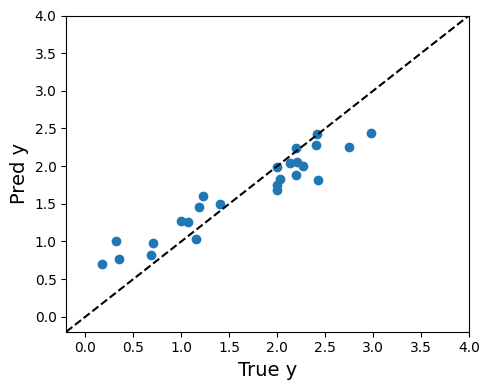

In [342]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.scatter(y, ml_model.predict(X))
ax1.plot([-0.2,4], [-0.2,4], '--k')

ax1.set_xlabel("True y", fontsize=14)
ax1.set_ylabel("Pred y", fontsize=14)

ax1.set_xlim([-0.2,4])
ax1.set_ylim([-0.2,4])

plt.tight_layout()

### 2.1 Compute Expected improvement for Candidate pool

In [343]:
trade_off = 0.01
y_pred, y_std = ml_model.predict(candidate_X, return_std=True)
y_train, y_train_std = ml_model.predict(X, return_std=True)

# Needed for noise-based model,
# otherwise use np.max(Y_train)
mu_train_opt = np.max(y_train)

with np.errstate(divide='warn'):
    imp = y_pred - mu_train_opt - trade_off
    Z = imp / y_std
    ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
    ei[y_std == 0.0] = 0.0

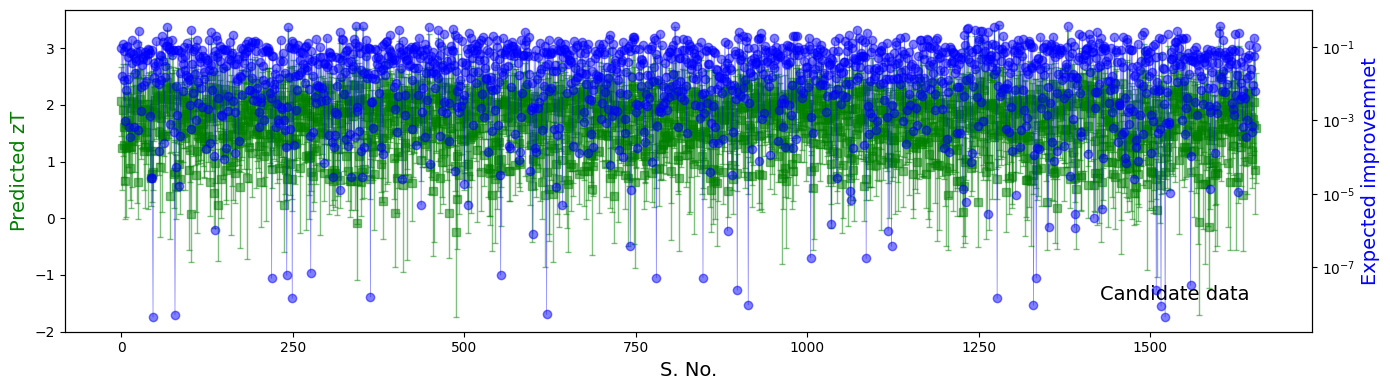

In [344]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,4))

ax1.errorbar(np.arange(len(y_pred)), y_pred, y_std, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted zT', fontsize=14, color='g')

ax1.text(0.95, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei, '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Better visualization: Plot for first 50 candidates

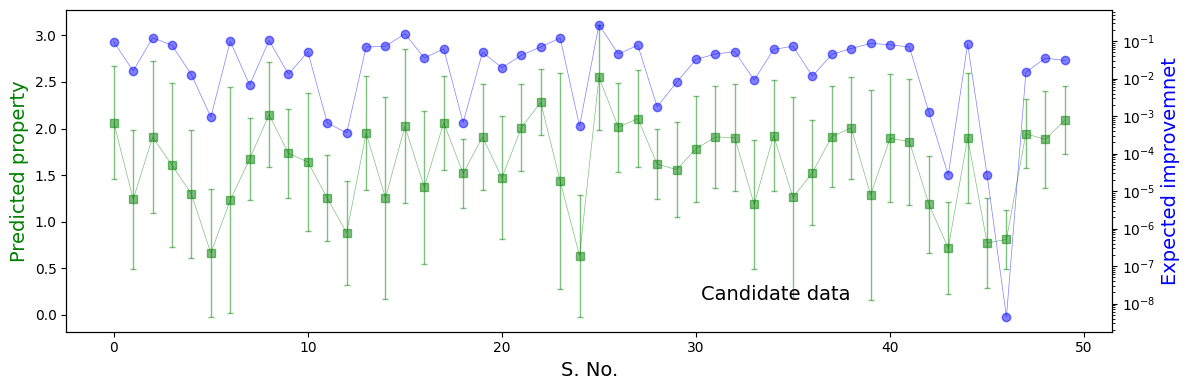

In [345]:
nplots = 50
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

ax1.errorbar(np.arange(len(y_pred))[:nplots], y_pred[:nplots], y_std[:nplots], fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=0.5)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Predicted property', fontsize=14, color='g')

ax1.text(0.75, 0.1, "Candidate data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([-0.2,0.5])

ax2 = ax1.twinx()

ax2.plot(ei[:nplots], '-bo', lw=0.5, alpha=0.5)
ax2.set_yscale('log')
ax2.set_ylabel('Expected improvemnet', fontsize=14, color='b')

plt.tight_layout()
plt.show()



### Question
1. Do you notice any trend in the EI value? When is it small and when is it large?

 EI values are generally small for candidate materials with lower predicted value compared to the best observation in the training dataset and high uncertainty.

 EI tend to be larger for candidate materials with  higher predicted values and lower uncertainty, indicating greater potential for improvement.

 If the predicted value and the certanity is low there is less chance of expected improvement.

### 2.2 Selecting candidate with maximum EI

In [346]:
print("Best target property sample so far in the train data is %.4f" %best_train)

Best target property sample so far in the train data is 2.9800


In [347]:
sel_idx = np.argmax(ei)

print("Selected candidate for next experiment ", candidate_data.iloc[sel_idx]['formula'])

Selected candidate for next experiment  CaF2


### 2.3 Next we do the experimnet and find the actual value

In [348]:
# Assume the experimnet was performed the zT value was measured
print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])

Exp. value for the selected candidate 9.9200


### 2.4 Next we update the training data and candidate pool

In [349]:
# Add selected data to training data
train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)

# Delete selected data from candidate pool
candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)

In [350]:
print("New train data size:", len(train_data), "\nNew candidate data size: ", len(candidate_data))

New train data size: 26 
New candidate data size:  1654


### 3.1 Complete Active learning loop (with Expected Impeovemnet)
Next we perform all steps in active learning in a loop for 50 steps and accumulate the results

In [351]:
results_ei = []

In [352]:
hyperparams={'kernel': [cv_results.iloc[0]['kernel']],
            'alpha':[cv_results.iloc[0]['alpha']]}

In [353]:
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [354]:
nloop = 50

In [284]:
trade_off = 0.01
for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

    # Step 2: Evaluate Acquisition function
    ei = expected_improvement(candidate_X, X, ml_model, trade_off)

    # Step 3: Select best candidate
    sel_idx = np.argmax(ei)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_ei.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Sn3WO6
Exp. value for the selected candidate 2.4900
Training data size:  501 
 Candidate pool size:  1654
Selected candidate Na2Mo2Se2O11
Exp. value for the selected candidate 3.1000
Training data size:  502 
 Candidate pool size:  1653
Selected candidate KNb3(TeO6)2
Exp. value for the selected candidate 3.5200
Training data size:  503 
 Candidate pool size:  1652
Selected candidate Li3GaTe4O11
Exp. value for the selected candidate 3.8500
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Sr3Ti2O7
Exp. value for the selected candidate 3.2600
Training data size:  505 
 Candidate pool size:  1650
Selected candidate Ga1.6Cu0.4S2.6
Exp. value for the selected candidate 2.4500
Training data size:  506 
 Candidate pool size:  1649
Selected candidate Ba2InSbSe5
Exp. value for the selected candidate 1.9200
Training data size:  507 
 Candidate pool size:  1648
Selected candidate Li2ZnSnS4
Exp. value for the selected candidate 2.8700
Training data size:  

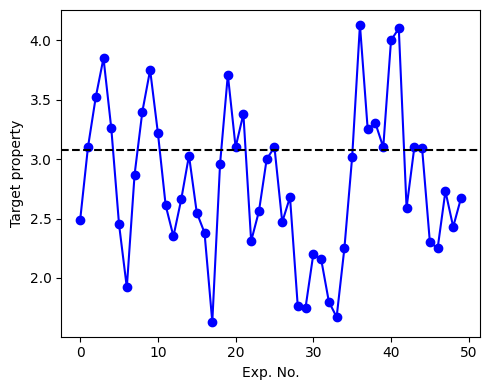

In [285]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_ei, '-bo', label='EI')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')

plt.tight_layout()

In [286]:
max(results_ei)

4.13

In [287]:
(results_ei > best_train).sum()

19

In [288]:
np.argmax(results_ei)

36

### 3.2 Active learning loop (with only Exploitation)

In [289]:
results_exploit = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [290]:
for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

    # Step 2: Evaluate Acquisition function
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)

    # Step 3: Select best candidate
    sel_idx = np.argmax(y_pred)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_exploit.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Cd3Te2MoO10
Exp. value for the selected candidate 3.8100
Training data size:  501 
 Candidate pool size:  1654
Selected candidate Zn4.5Ga1Sn0.5O7
Exp. value for the selected candidate 3.0000
Training data size:  502 
 Candidate pool size:  1653
Selected candidate Zn5.5Ga1Sn0.5O8
Exp. value for the selected candidate 2.9900
Training data size:  503 
 Candidate pool size:  1652
Selected candidate Na2Mo2Se2O11
Exp. value for the selected candidate 3.1000
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Li3GaTe4O11
Exp. value for the selected candidate 3.8500
Training data size:  505 
 Candidate pool size:  1650
Selected candidate Sr3Ti2O7
Exp. value for the selected candidate 3.2600
Training data size:  506 
 Candidate pool size:  1649
Selected candidate Ga1.7Cu0.3S2.7
Exp. value for the selected candidate 2.5500
Training data size:  507 
 Candidate pool size:  1648
Selected candidate Zn0.95Ga0.05P0.05Se0.95
Exp. value for the selected candidate 

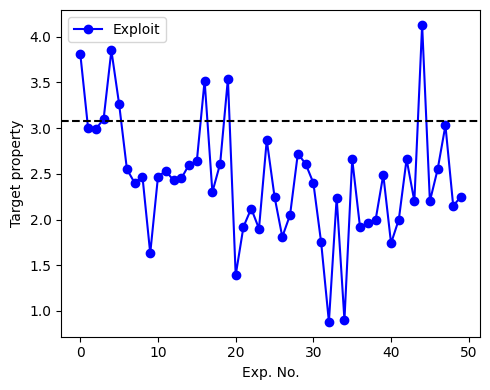

In [291]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_exploit, '-bo', label='Exploit')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [292]:
(results_exploit > best_train).sum()

7

In [293]:
max(results_exploit)

4.13

In [294]:
np.argmax(results_exploit)

44

### 3.3 Active learning loop (with only Exploration)

In [295]:
results_explore = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [296]:
for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

    # Step 2: Evaluate Acquisition function
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)

    # Step 3: Select best candidate
    sel_idx = np.argmax(y_std)
    print("Selected candidate", candidate_data.iloc[sel_idx]['formula'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_explore.append(candidate_data.iloc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Lu2O3
Exp. value for the selected candidate 5.5000
Training data size:  501 
 Candidate pool size:  1654
Selected candidate Eu2O3
Exp. value for the selected candidate 4.5000
Training data size:  502 
 Candidate pool size:  1653
Selected candidate BaO
Exp. value for the selected candidate 4.8000
Training data size:  503 
 Candidate pool size:  1652
Selected candidate Cs3Bi2Br9
Exp. value for the selected candidate 2.5000
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Cu1.8S1
Exp. value for the selected candidate 2.3000
Training data size:  505 
 Candidate pool size:  1650
Selected candidate LaCuSeO
Exp. value for the selected candidate 2.8300
Training data size:  506 
 Candidate pool size:  1649
Selected candidate Ti6H2O13
Exp. value for the selected candidate 3.4000
Training data size:  507 
 Candidate pool size:  1648
Selected candidate FeBi(SeO3)3
Exp. value for the selected candidate 2.5400
Training data size:  508 
 Candidate pool size:

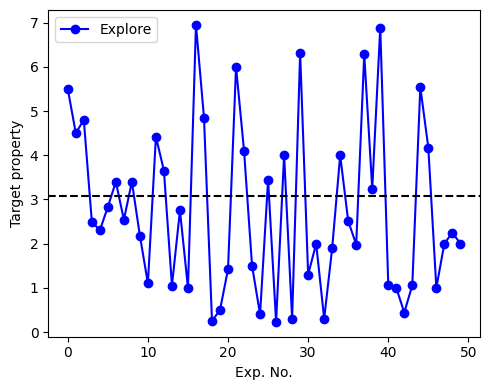

In [297]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_explore, '-bo', label='Explore')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [298]:
(results_explore > best_train).sum()

20

In [299]:
max(results_explore)

6.95

### 3.4 Active learning with random selection

In [300]:
results_random = []
train_data = train_data_ori.copy()
candidate_data = candidate_data_ori.copy()

In [301]:
for exp_idx in range(nloop):

    # Step 3: Select candidate
    sel_idx = np.random.choice(candidate_data.index)
    print("Selected candidate", candidate_data.loc[sel_idx]['formula'])

    # Step 4: Perform experimnet and update training and candidate data pool
    results_random.append(candidate_data.loc[sel_idx][target_col])
    print("Exp. value for the selected candidate %.4f" %candidate_data.loc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.loc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.loc[sel_idx].name)
    print("Training data size: ", len(train_data), "\n Candidate pool size: ", len(candidate_data))

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

Selected candidate Ca2Si
Exp. value for the selected candidate 1.9000
Training data size:  501 
 Candidate pool size:  1654
Selected candidate K2Cd3Te4
Exp. value for the selected candidate 2.2600
Training data size:  502 
 Candidate pool size:  1653
Selected candidate ZnSnO3
Exp. value for the selected candidate 3.9000
Training data size:  503 
 Candidate pool size:  1652
Selected candidate Li4.5Mn0.5Te1O6
Exp. value for the selected candidate 1.9700
Training data size:  504 
 Candidate pool size:  1651
Selected candidate Sr(PrS2)2
Exp. value for the selected candidate 2.7000
Training data size:  505 
 Candidate pool size:  1650
Selected candidate GeO2
Exp. value for the selected candidate 5.5400
Training data size:  506 
 Candidate pool size:  1649
Selected candidate Al0.3In0.7P1
Exp. value for the selected candidate 1.9000
Training data size:  507 
 Candidate pool size:  1648
Selected candidate BaZnGeSe4
Exp. value for the selected candidate 2.4600
Training data size:  508 
 Candida

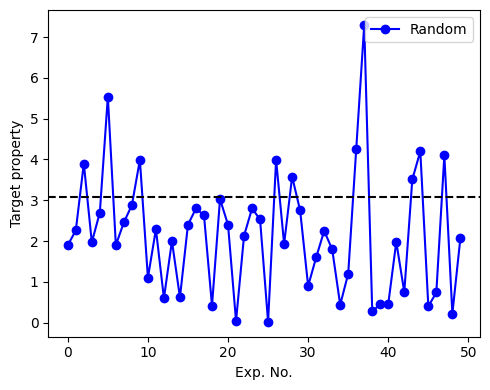

In [302]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(results_random, '-bo', label='Random')
ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.')
ax1.set_ylabel('Target property')
ax1.legend()

plt.tight_layout()

In [303]:
(results_random > best_train).sum()

10

In [304]:
np.argmax(results_random)

37

### 4.1 Comparision Plot: Results from various acquisition function

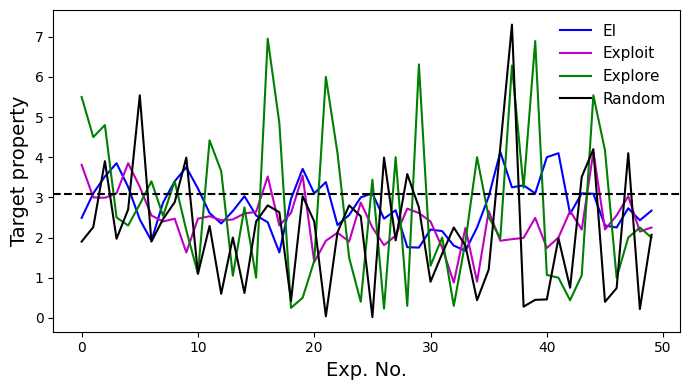

In [305]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

ax1.plot(results_ei, c='b', label='EI')
ax1.plot(results_exploit, c='m', label='Exploit')
ax1.plot(results_explore, c='g', label='Explore')
ax1.plot(results_random, c='k', label='Random')


ax1.axhline(y=best_train, linestyle = '--', c='k')
ax1.set_xlabel('Exp. No.', fontsize=14)
ax1.set_ylabel('Target property', fontsize=14)
ax1.legend(frameon=False, fontsize=11)

plt.tight_layout()


### 4.2 Comparision Plot: Distribution of target property of new candidates

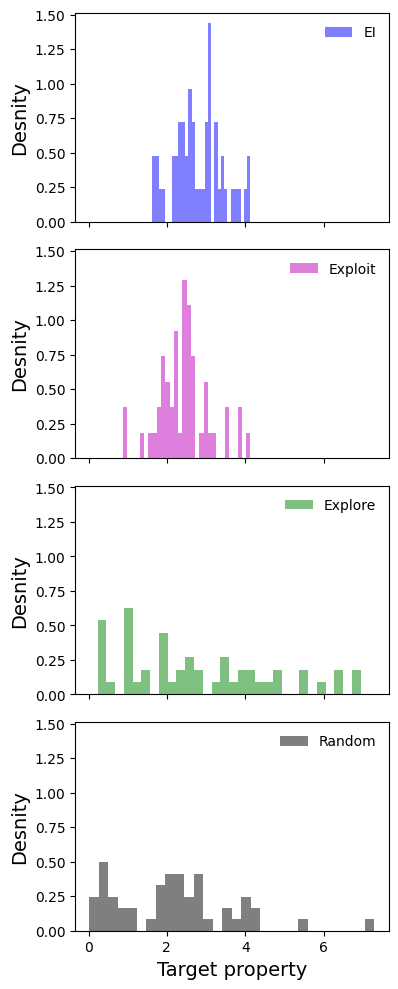

In [306]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(4,10), sharex=True, sharey=True)
axs = axs.ravel()
all_results = [results_ei, results_exploit, results_explore, results_random]
cols = ['b', 'm', 'g', 'k']
labels = ['EI','Exploit','Explore','Random']

for res, ax, c, l in zip(all_results, axs, cols, labels):
    ax.hist(res, bins=30, alpha=0.5, density=True, color=c, label=l)
    ax.legend(frameon=False)
    ax.set_ylabel('Desnity', fontsize=14)

ax.set_xlabel('Target property', fontsize=14)
plt.tight_layout()

### Question

2. Does EI and exploitation always perform better than exploration/random search?

In most of the cases Expected Improvement and the exploitation will perfoem better than exploration due to few reasons:
* Exploration gets to search over the regions which has more likely to find a better candidate based on the previous insights but in these type of cases it may lead to get stuck at a point.
* In Exploration it priorities the discovery of new samples from the regions and doesn't involve the prior information which leads to slower convergence.
* In random search it tries to reproduce the new distribution rather than finding the best candidate based on the prior information.


3. What other improvemnets can be made in terms of ML model training?

In the above code provided we have use a parameter `n_frac=0.5` if we increase this parameter so while training the model it would consider more apt training dataset which would eventually lead to better model with more optimized parameters

4. Try different values of the nfrac parameter and see how many trials does the different acquisition functions take ON AVERAGE to suggest the highest bandgap system (=11.7 eV)? Remember for each value of nfrac you will have to run the above code multiple times to get good statistics. Convey your results using plots.

In [307]:
train_data = pd.read_csv('active-learning-eg-train.csv')
train_data_ori = train_data.copy()
candidate_data = pd.read_csv('active-learning-eg-candidate.csv')
candidate_data = candidate_data.sample(frac=1, random_state=1)
candidate_data_ori = candidate_data.copy()

In [308]:
hyperparams={'kernel': [cv_results.iloc[0]['kernel']],
            'alpha':[cv_results.iloc[0]['alpha']]}

In [309]:
nloop = 50
trade_off = 0.01

In [355]:
nfrac = [0.02,0.05,0.08,0.1,0.2,0.5,0.8,1]
Ei_trials = []

In [356]:
for Nfrac in nfrac:
  train_data = train_data_ori.sample(frac=Nfrac)
  candidate_data = candidate_data_ori.copy()

  X = train_data[Xcols]
  candidate_X = candidate_data[Xcols]

  target_col = 'gap expt'
  y = train_data[target_col]

  print('nfrac=',Nfrac)
  results_ei = []

  for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

      # Step 2: Evaluate Acquisition function
    ei = expected_improvement(candidate_X, X, ml_model, trade_off)

      # Step 3: Select best candidate
    sel_idx = np.argmax(ei)

      # Step 4: Perform experimnet and update training and candidate data pool
    results_ei.append(candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)


    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

  print(max(results_ei))
  print(np.argmax(results_ei))
  Ei_trials.append(np.argmax(results_ei))
  print()

nfrac= 0.02
11.7
6

nfrac= 0.05
11.7
10

nfrac= 0.08
11.7
5

nfrac= 0.1
11.7
2

nfrac= 0.2
11.7
3

nfrac= 0.5
11.7
3

nfrac= 0.8
11.7
11

nfrac= 1
11.7
10



In [366]:
Exploit_trials = []

In [367]:
for Nfrac in nfrac:
  train_data = train_data_ori.sample(frac=Nfrac)
  candidate_data = candidate_data_ori.copy()

  X = train_data[Xcols]
  candidate_X = candidate_data[Xcols]

  target_col = 'gap expt'
  y = train_data[target_col]


  print('nfrac=',Nfrac)
  results_exploit = []

  for exp_idx in range(nloop):

    # Step 1: Train ML model
    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)

    # Step 2: Evaluate Acquisition function
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)

    # Step 3: Select best candidate
    sel_idx = np.argmax(y_pred)

    # Step 4: Perform experimnet and update training and candidate data pool
    results_exploit.append(candidate_data.iloc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

  print(max(results_exploit))
  print(np.argmax(results_exploit))
  Exploit_trials.append(np.argmax(results_exploit))
  print()

nfrac= 0.02
7.33
47

nfrac= 0.05
11.7
1

nfrac= 0.08
11.7
49

nfrac= 0.1
11.7
9

nfrac= 0.2
11.7
6

nfrac= 0.5
11.7
12

nfrac= 0.8
11.7
14

nfrac= 1
11.7
14

nfrac= 0.02
11.7
3

nfrac= 0.05
11.1
25

nfrac= 0.08
11.7
12

nfrac= 0.1
11.7
8

nfrac= 0.2
11.7
20

nfrac= 0.5
11.7
28

nfrac= 0.8
11.7
13

nfrac= 1
11.7
14



In [368]:
Explore_trials = []

In [369]:
for Nfrac in nfrac:
  train_data = train_data_ori.sample(frac=Nfrac)
  candidate_data = candidate_data_ori.copy()

  X = train_data[Xcols]
  candidate_X = candidate_data[Xcols]

  target_col = 'gap expt'
  y = train_data[target_col]

  print('nfrac=',Nfrac)
  results_explore = []

  for exp_idx in range(nloop):

    ml_model = train_gpr_model(X,y,hyperparams=hyperparams)
    y_pred, y_std = ml_model.predict(candidate_X, return_std=True)
    sel_idx = np.argmax(y_std)
    results_explore.append(candidate_data.iloc[sel_idx][target_col])

    train_data = pd.concat([train_data, candidate_data.iloc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.iloc[sel_idx].name)

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

  print(max(results_explore))
  print(np.argmax(results_explore))
  Explore_trials.append(np.argmax(results_explore))
  print()

nfrac= 0.02
11.7
6

nfrac= 0.05
11.7
7

nfrac= 0.08
11.7
20

nfrac= 0.1
11.7
18

nfrac= 0.2
11.7
17

nfrac= 0.5
11.7
28

nfrac= 0.8
11.7
22

nfrac= 1
11.7
21

nfrac= 0.02
11.7
9

nfrac= 0.05
11.7
24

nfrac= 0.08
11.7
23

nfrac= 0.1
11.7
20

nfrac= 0.2
11.7
17

nfrac= 0.5
11.7
22

nfrac= 0.8
11.7
24

nfrac= 1
11.7
21



In [370]:
random_trials = []

In [371]:
for Nfrac in nfrac:
  train_data = train_data_ori.sample(frac=Nfrac)
  candidate_data = candidate_data_ori.copy()

  X = train_data[Xcols]
  candidate_X = candidate_data[Xcols]

  target_col = 'gap expt'
  y = train_data[target_col]

  print('nfrac=',Nfrac)
  results_random = []

  for exp_idx in range(nloop):


    sel_idx = np.random.choice(candidate_data.index)
    results_random.append(candidate_data.loc[sel_idx][target_col])
    train_data = pd.concat([train_data, candidate_data.loc[sel_idx].to_frame().T], ignore_index=True)
    candidate_data = candidate_data.drop(index=candidate_data.loc[sel_idx].name)

    X = train_data[Xcols]
    candidate_X = candidate_data[Xcols]
    y = train_data[target_col]

  print(max(results_random))
  print(np.argmax(results_random))
  random_trials.append(np.argmax(results_random))
  print()

nfrac= 0.02
6.31
28

nfrac= 0.05
11.7
14

nfrac= 0.08
5.17
5

nfrac= 0.1
7.33
23

nfrac= 0.2
10.0
43

nfrac= 0.5
5.6
25

nfrac= 0.8
6.4
0

nfrac= 1
4.81
41



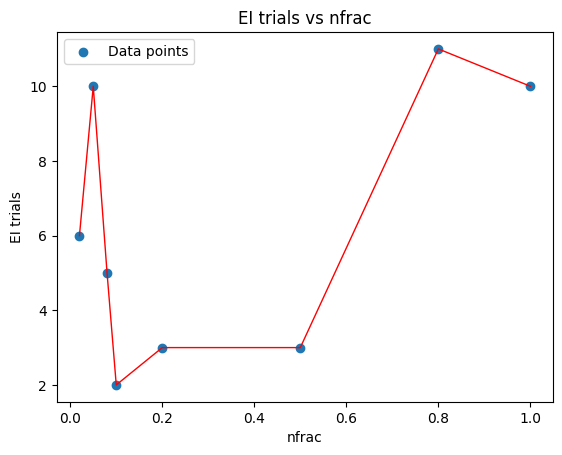

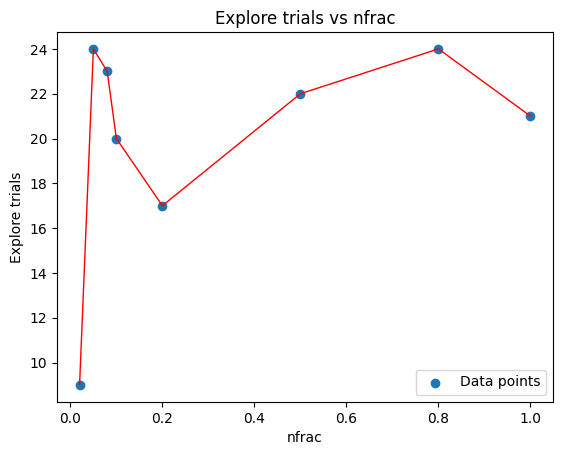

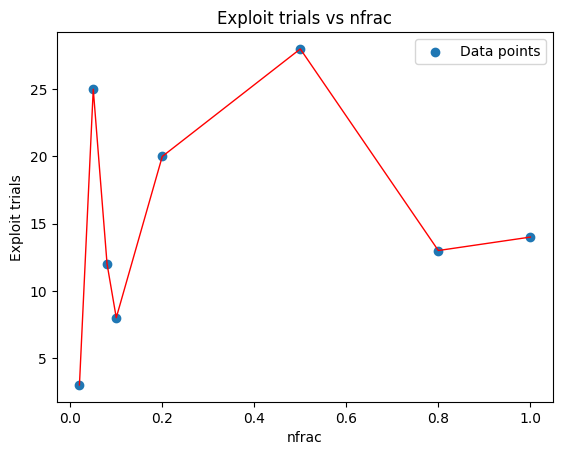

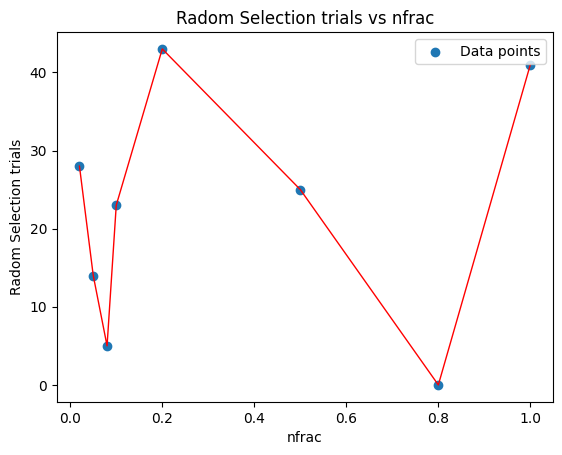

In [374]:
plt.scatter(nfrac, Ei_trials, label='Data points')
plt.plot(nfrac, Ei_trials, color='red', linestyle='-', linewidth=1, )
plt.xlabel('nfrac')
plt.ylabel('EI trials')
plt.title('EI trials vs nfrac')
plt.legend()
plt.show()

plt.scatter(nfrac, Explore_trials, label='Data points')
plt.plot(nfrac, Explore_trials, color='red', linestyle='-', linewidth=1, )
plt.xlabel('nfrac')
plt.ylabel('Explore trials')
plt.title('Explore trials vs nfrac')
plt.legend()
plt.show()


plt.scatter(nfrac, Exploit_trials, label='Data points')
plt.plot(nfrac, Exploit_trials, color='red', linestyle='-', linewidth=1, )
plt.xlabel('nfrac')
plt.ylabel('Exploit trials')
plt.title('Exploit trials vs nfrac')
plt.legend()
plt.show()

plt.scatter(nfrac, random_trials, label='Data points')
plt.plot(nfrac, random_trials, color='red', linestyle='-', linewidth=1, )
plt.xlabel('nfrac')
plt.ylabel('Radom Selection trials')
plt.title('Radom Selection trials vs nfrac')
plt.legend()
plt.show()

In [372]:
Avg_EI = np.ceil(np.mean(Ei_trials))
Avg_Exploit = np.ceil(np.mean(Exploit_trials))
Avg_Explore = np.ceil(np.mean(Explore_trials))
Avg_random = np.ceil(np.mean(random_trials))

print('Avg number of trials using EI:',Avg_EI)
print('Avg number of trials using Explore:',Avg_Explore)
print('Avg number of trials using Exploit:',Avg_Exploit)
print('Avg number of trials using Random Section:',Avg_random)

Avg number of trials using EI: 7.0
Avg number of trials using Explore: 20.0
Avg number of trials using Exploit: 16.0
Avg number of trials using Random Section: 23.0


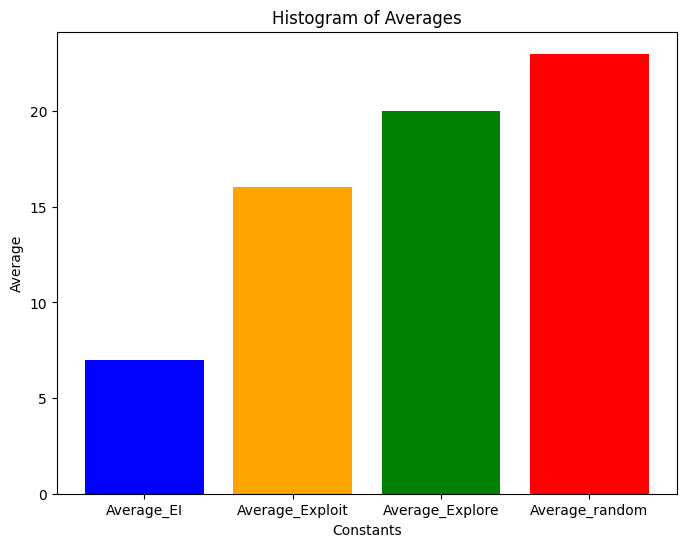

In [373]:
data = [Avg_EI, Avg_Exploit, Avg_Explore,Avg_random]
labels = ['Average_EI', 'Average_Exploit', 'Average_Explore','Average_random']


plt.figure(figsize=(8, 6))
plt.bar(labels, data, color=['blue', 'orange', 'green','red'])
plt.xlabel('Constants')
plt.ylabel('Average')
plt.title('Histogram of Averages')
plt.show()